# Models generation

In this notebook, we will explore various ways of creating a model for our simulation.

## Three-layer model

First, let's start by creating a single layer model with the following characteristics :

\begin{array}{|c|c|}
\hline V_p \hspace{2mm} (m  / s) & Depth \hspace{2mm} (m) \\\hline
  \hspace{2cm} 3500 \hspace{2cm} & \hspace{2cm} 120 \hspace{2cm} \\\hline
  2000 & 200 \\\hline
  2500 & 280 \\\hline
\end{array}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from SeisCL import SeisCL

Again, we initially have to define basics simulation constants to create the model. Here we're going to use $2 \, m$ spatial spacing with $300$ grid points deep and $500$ points wide which will give us a $600 \times 1000 m $ domain.

In [3]:
seis3Layers = SeisCL()

seis3Layers.csts['ND'] = 2
seis3Layers.csts['N'] = np.array([300, 500])
seis3Layers.csts['dt'] = dt = 0.25e-03
seis3Layers.csts['dh'] = dh = 2
seis3Layers.csts['NT'] = NT = 1500
seis3Layers.csts['FDORDER'] = 4

seis3Layers.csts['seisout'] = 1

We then fill the domain with a source and receivers near the surface.

In [4]:
seis3Layers.fill_src_rec_reg()

Now let's create the model over which the simulation will take place. This consists of a matrix  $\small \left[ N_z \times N_x \right]$ where each points got assigned a velocity.

The formulation $\small \left[N_z, N_x, N_y\right]$ instead of $\small \left[N_x, N_y, N_z\right]$ in the definition of the domain is extremely useful during the construction of the models since this one allows to create a matrix which corresponds exactly to the desired model, without performing any transpose operation. 

In [5]:
Nz = seis3Layers.csts['N'][0]
Nx = seis3Layers.csts['N'][1]

vp = [3500, 2000, 2500]
vs = 2000
rho = 2000
taup = 0
taus = 0

Ep_vp = [Nz//5, Nz//3]

vp_1 = np.zeros((Ep_vp[0], Nx)) + vp[0]
vp_2 = np.zeros((Ep_vp[1], Nx)) + vp[1]
vp_3 = np.zeros((Nz-np.sum(Ep_vp), Nx)) + vp[2]

vp_all = np.vstack((vp_1, vp_2, vp_3))

vs_all = np.zeros(seis3Layers.csts['N']) + vs
rho_all = np.zeros(seis3Layers.csts['N']) + rho
taup_all = np.zeros(seis3Layers.csts['N']) + taup
taus_all = np.zeros(seis3Layers.csts['N']) + taus


Model3Layers = {"vp": vp_all, "rho": rho_all, "vs": vs_all, "taup": taup_all, "taus": taus_all}

Before running our simulation, we want to visualize the domain to ensure that the model is correct.

We can create a figure using `matplotlib`, and pass the figure axis to the `DrawDomain2D` function.

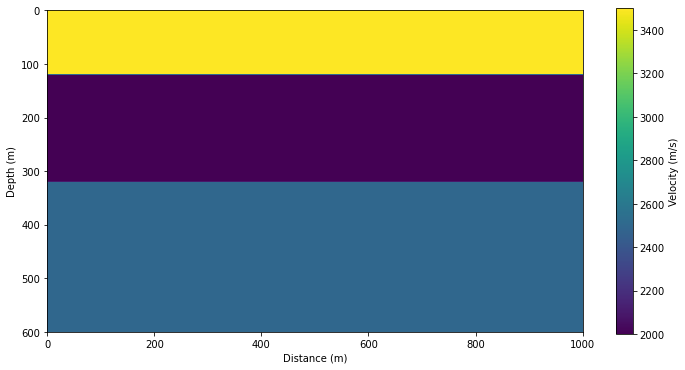

In [8]:
_, ax = plt.subplots(1, 1, figsize = (12,6))
seis3Layers.DrawDomain2D(vp_all, ax = ax)

Finally, we can launch the simulation and visualize the result with matplotlib.

In [6]:
gsid = seis3Layers.src_pos_all[3]
seis3Layers.set_forward(gsid, Model3Layers, withgrad=False) #TODO changer dépendance set_foward à jobids
seis3Layers.execute()
data3Layers = seis3Layers.read_data()

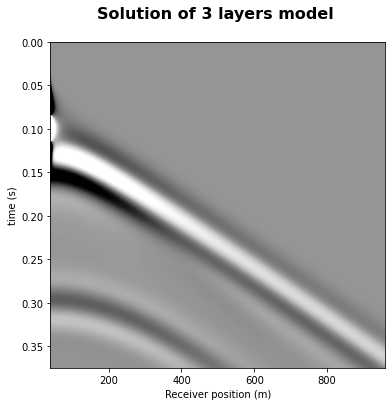

In [7]:
clip = 0.1
extent = [min(seis3Layers.rec_pos_all[0]), max(seis3Layers.rec_pos_all[0]), (data3Layers.shape[0]-1)*dt, 0]
vmax = np.max(data3Layers) * clip
vmin = -vmax
_, ax3 = plt.subplots(1, 1, figsize=[6, 6])
ax3.imshow(data3Layers, aspect='auto', vmax=vmax, vmin=vmin, extent = extent,
                interpolation='bilinear', cmap=plt.get_cmap('Greys'))
ax3.set_title("Solution of 3 layers model \n", fontsize=16, fontweight='bold')
ax3.set_xlabel("Receiver position (m)")
ax3.set_ylabel("time (s)")
plt.show()

## Marmousi model



In [16]:
import os
from urllib.request import urlretrieve

url = "http://sw3d.cz/software/marmousi/little.bin/velocity.h@"
if not os.path.isfile("velocity.h@"):
    urlretrieve(url, filename="velocity.h@")
vel = np.fromfile("velocity.h@", dtype=np.float32)

vp = np.transpose(np.reshape(np.array(vel), [2301, 751]))

vp = vp[::4, ::4]
(NZ, NX) = vp.shape
NZ = int(NZ / 2) * 2
NX = int(NX / 2) * 2
vp = vp[:NZ, :NX]

rho = vp * 0 + 2000
vs = vp * 0

modelMarmousi = {'vp':vp, 'vs':vs, 'rho':rho}

In [22]:
seisMarmousi = SeisCL()
seisMarmousi.csts['N'] = np.array([vp.shape[0], vp.shape[1]])
seisMarmousi.csts['ND'] = 2
seisMarmousi.csts['dt'] = dt = 6 * dh / (7 * np.sqrt(2) * np.max(vp)) * 0.85
seisMarmousi.csts['NT'] = int(2 / seisMarmousi.csts['dt'])

In [23]:
seisMarmousi.fill_src_rec_reg()

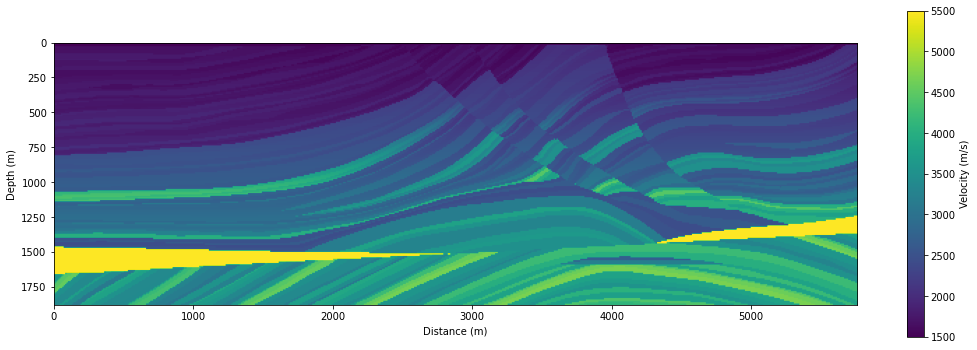

In [24]:
_, ax = plt.subplots(1, 1, figsize = (18, 6))
seisMarmousi.DrawDomain2D(vp, ax = ax)

In [25]:
gsid = seisMarmousi.src_pos_all[3]
seisMarmousi.set_forward(gsid, modelMarmousi, withgrad=False)
seisMarmousi.execute()
dataMarmousi = seisMarmousi.read_data()

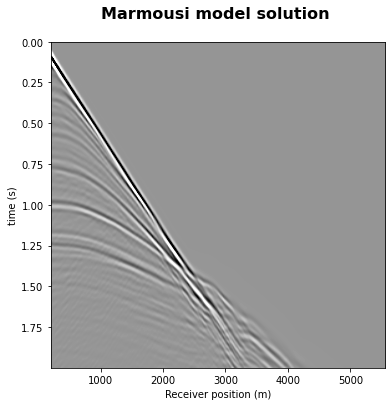

In [27]:
clip = 0.1
extent = [min(seisMarmousi.rec_pos_all[0]), max(seisMarmousi.rec_pos_all[0]), (dataMarmousi.shape[0]-1)*dt, 0]
vmax = np.max(dataMarmousi) * clip
vmin = -vmax
_, axR = plt.subplots(1, 1, figsize=[6, 6])
axR.imshow(dataMarmousi, aspect='auto', vmax=vmax, vmin=vmin, extent = extent,
                interpolation='bilinear', cmap=plt.get_cmap('Greys'))
axR.set_title("Marmousi model solution \n", fontsize=16, fontweight='bold')
axR.set_xlabel("Receiver position (m)")
axR.set_ylabel("time (s)")
plt.show()